In [1]:
# organize imports
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import normalize
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
import keras.backend as K
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import random
import pydot
import tensorflow as tf


Using TensorFlow backend.


In [2]:
# seed for reproducing same results
seed = 9
np.random.seed(seed)



# Load data and create test and training inputs and outputs

In [3]:
# filenames must be a list
def loadData(filenames, testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"]):
    # load simple dataset
    for i, filename in enumerate(filenames):
        PATH_FILE_TRAINING3 = os.getcwd()+"/"+filename
        f = h5py.File(PATH_FILE_TRAINING3, "r")
        # split into input and output variables
        if i==0:
            X       = f[fieldNames[0]].value;     
            X      = X.transpose();
            Y        = f[fieldNames[1]].value;      
            Y       = Y.transpose();
        else:
            X1       = f[fieldNames[0]].value;     
            X1      = X1.transpose();
            Y1        = f[fieldNames[1]].value;      
            Y1       = Y1.transpose();
            X = np.vstack((X,X1))
            Y = np.vstack((Y,Y1))   
    
    # split the data into training (75%) and testing (25%)
    (X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=testRatio, random_state=seed)

    # Examine shape of data
#     print(np.shape(X))
#     print(np.shape(Y))
#     print(np.shape(X_train))
#     print(np.shape(X_test))
#     print(np.shape(Y_train))
#     print(np.shape(Y_test))
    return X_train, X_test, Y_train, Y_test



# Create custom metric to print learning rate after each epoch

In [4]:
class CustomMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        current_lr = K.eval(self.model.optimizer.lr)
        lrHist.append(current_lr)
        print("Learning rate: ",current_lr)

# Function to plot trajectory from row of training data

In [5]:
def plotTrajectoryFromInput(X_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    x = X_data[0:120:6] 
    y = X_data[1:120:6]
#     print(np.shape(x))
#     print(np.shape(y))
    plt.plot(x, y)
    plt.title('Trajectory')
    plt.ylabel('y')
    plt.xlabel('x')
    # plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [6]:
def plotTrajectoryInputAndOutput(X_data, Y_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xIn = X_data[0:120:6] 
    yIn = X_data[1:120:6]
#     print(np.shape(xIn))
#     print(np.shape(yIn))
    
    xOut = xIn + Y_data[0:120:6]
    yOut = yIn + Y_data[1:120:6]
#     print(np.shape(xOut))
#     print(np.shape(yOut))
    
    plt.plot(xIn, yIn)
    plt.plot(xOut, yOut)
    plt.title('Trajectory')
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend(['input trajectory', 'expected output'], loc='upper right')
    plt.show()

In [7]:
def plotVelocitiesInputAndOutput(X_data, Y_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xDotIn = np.array(X_data[3:120:6])
    yDotIn = np.array(X_data[4:120:6])
    velIn = np.sqrt(xDotIn**2 + yDotIn**2)
#     print(np.shape(xIn))
#     print(np.shape(yIn))
    
    xDotOut = np.array(xDotIn + Y_data[3:120:6])
    yDotOut = np.array(yDotIn + Y_data[4:120:6])
    velOut = np.sqrt(xDotOut**2 + yDotOut**2)
#     print(np.shape(xOut))
#     print(np.shape(yOut))
    
    plt.plot(velIn)
    plt.plot(velOut)
    plt.title('Velocity')
    plt.ylabel('v')
    plt.xlabel('t')
    plt.legend(['input velocity', 'expected output velocity'], loc='upper right')
    plt.show()

In [8]:
def plotTrajectoryInputExpectedAndNN(X_data, Y_data, NN_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xIn = X_data[0:120:6] 
    yIn = X_data[1:120:6]
#     print(np.shape(xIn))
#     print(np.shape(yIn))
    
    xExp = xIn + Y_data[0:120:6]
    yExp = yIn + Y_data[1:120:6]
#     print(np.shape(xOut))
#     print(np.shape(yOut))

    xNN = xIn + NN_data[0:120:6]
    yNN = yIn + NN_data[1:120:6]
    
    plt.plot(xIn, yIn)
    plt.plot(xExp, yExp)
    plt.scatter(xNN, yNN,color='g')
    plt.title('Trajectory')
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend(['input trajectory', 'expected output', 'NN output'], loc='upper right')
    plt.show()

In [9]:
def plotVelocitiesInputExpectedAndNN(X_data, Y_data, NN_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xDotIn = np.array(X_data[3:120:6])
    yDotIn = np.array(X_data[4:120:6])
    velIn = np.sqrt(xDotIn**2 + yDotIn**2)
#     print(np.shape(xIn))
#     print(np.shape(yIn))
    
    xDotExp = np.array(xDotIn + Y_data[3:120:6])
    yDotExp = np.array(yDotIn + Y_data[4:120:6])
    velExp = np.sqrt(xDotExp**2 + yDotExp**2)
#     print(np.shape(xOut))
#     print(np.shape(yOut))
    xDotNN = np.array(xDotIn + NN_data[3:120:6])
    yDotNN = np.array(yDotIn + NN_data[4:120:6])
    velNN = np.sqrt(xDotNN**2 + yDotNN**2)
    
    plt.plot(velIn)
    plt.plot(velExp)
    plt.scatter(np.arange(np.size(velNN,0)), velNN,color='g')
    plt.title('Velocity')
    plt.ylabel('v')
    plt.xlabel('t')
    plt.legend(['input velocity', 'expected output velocity', 'NN output velocity'], loc='upper right')
    plt.show()

# Plot some trajectories from training and test

### Zero final velocity dataset (so only velocities change but trajectory is still straight line)

/usr/local/lib/python3.5/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Training data
Random i = 857


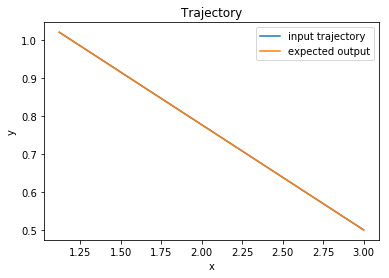

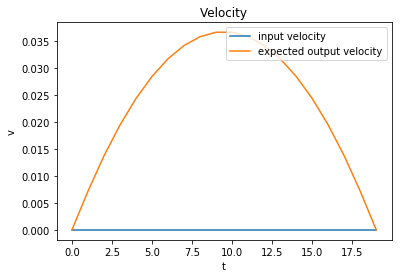

Random i = 1283


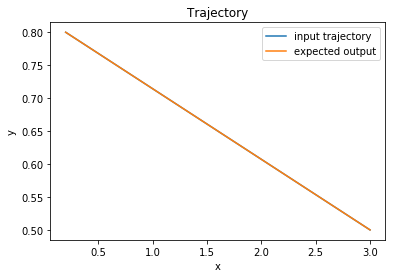

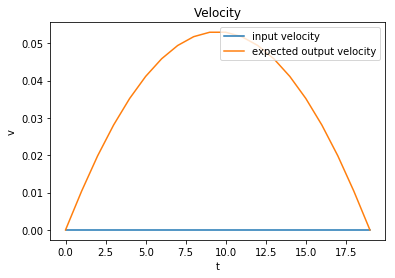

Random i = 1044


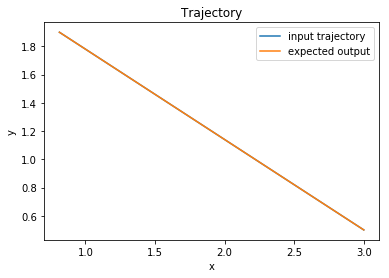

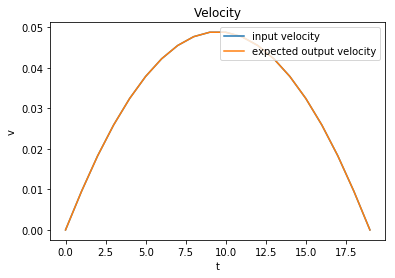

Random i = 17


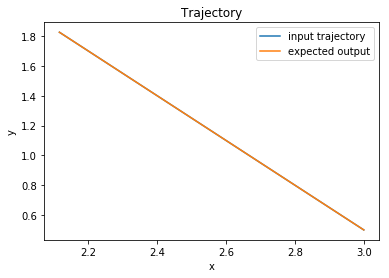

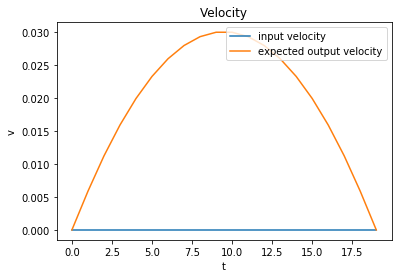

Random i = 1007


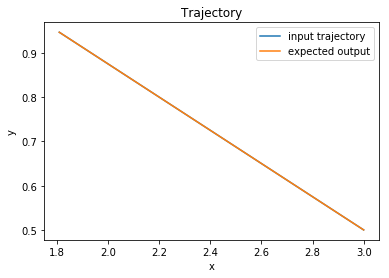

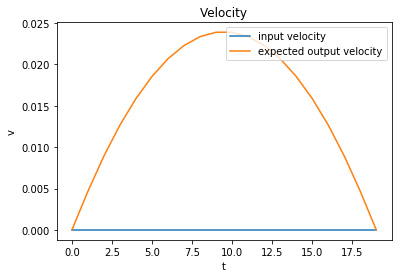

Random i = 5


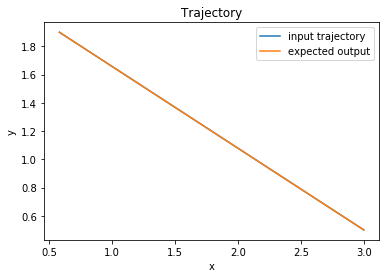

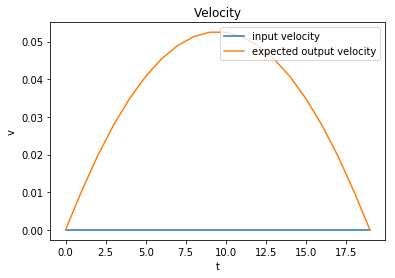

Random i = 434


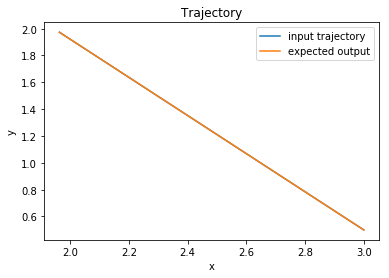

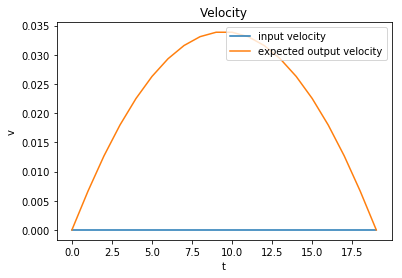

Random i = 293


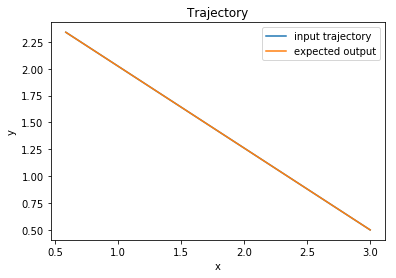

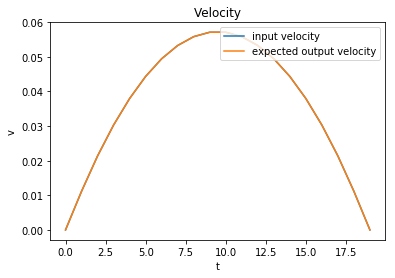

Test data
Random i = 305


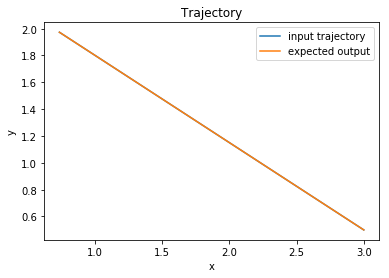

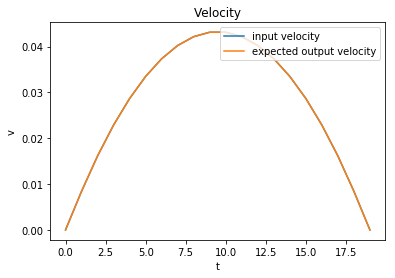

Random i = 204


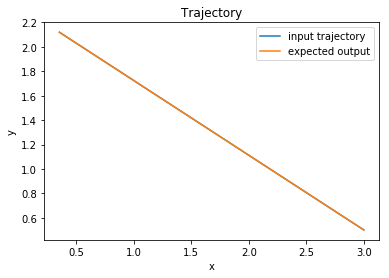

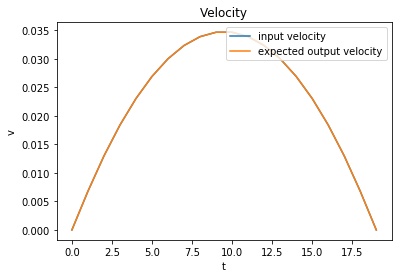

Random i = 48


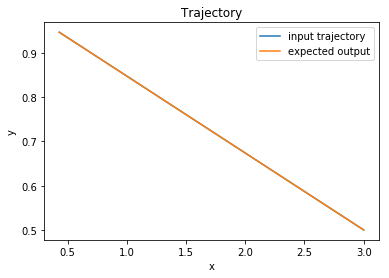

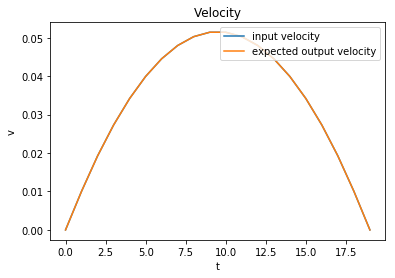

Random i = 48


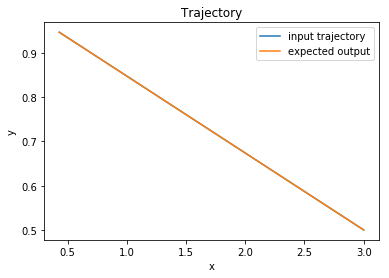

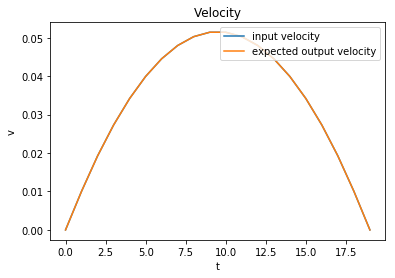

Random i = 476


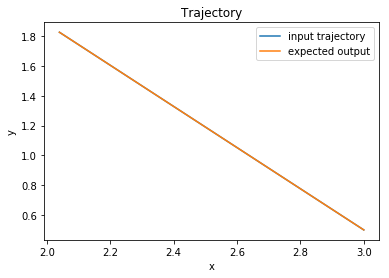

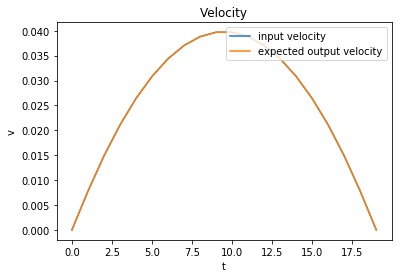

Random i = 123


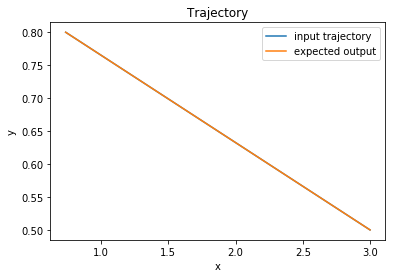

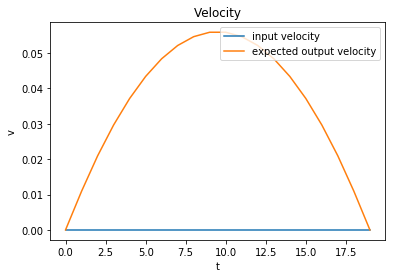

Random i = 111


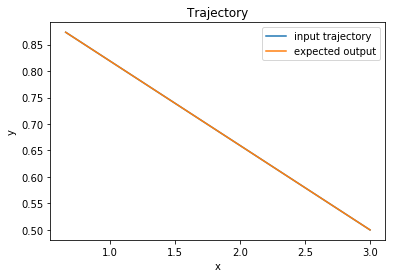

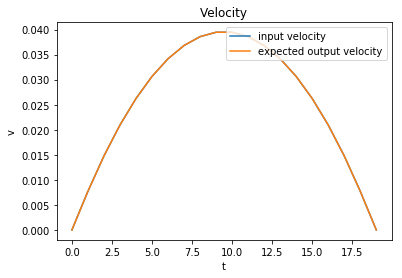

Random i = 459


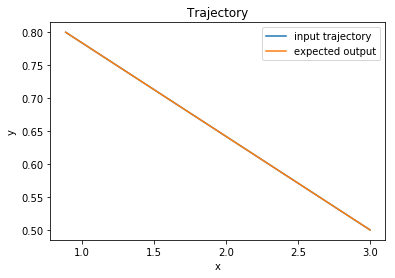

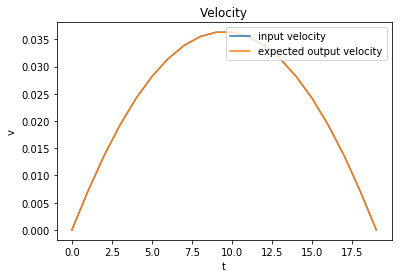

In [10]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVel.jld2"], testRatio = 0.25)

print("Training data")
for x in range(8):
    i = random.randint(1,np.size(X_train,0)-1)
    print("Random i =",i)
    plotTrajectoryInputAndOutput(X_train[i,:],Y_train[i,:])
    plotVelocitiesInputAndOutput(X_train[i,:],Y_train[i,:])
print("Test data")
for x in range(8):
    i = random.randint(1,np.size(X_test,0)-1)
    print("Random i =",i)
    plotTrajectoryInputAndOutput(X_test[i,:],Y_test[i,:])
    plotVelocitiesInputAndOutput(X_train[i,:],Y_train[i,:])



### Zero final velocity dataset with only first iterations of GuSTO stored

Training data
Random i = 62


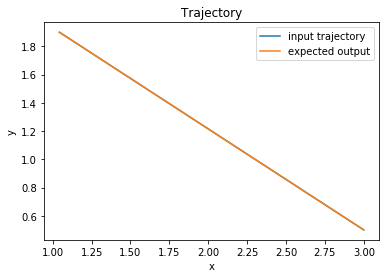

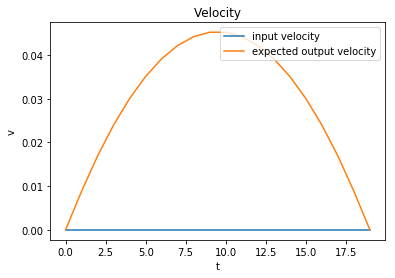

Random i = 65


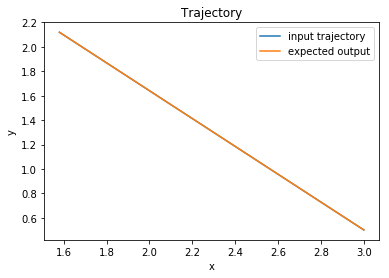

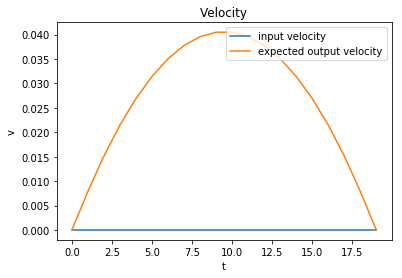

Random i = 104


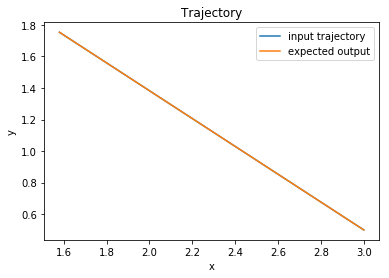

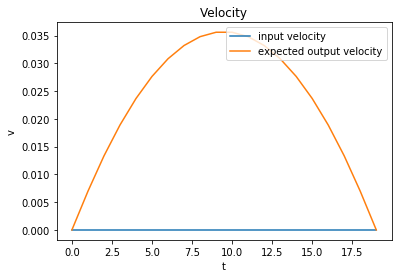

Random i = 156


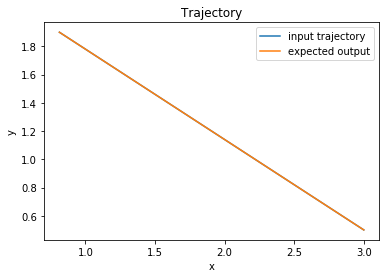

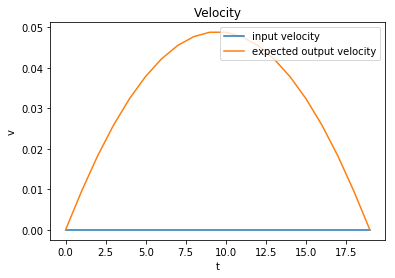

Random i = 232


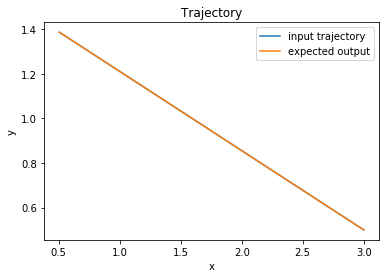

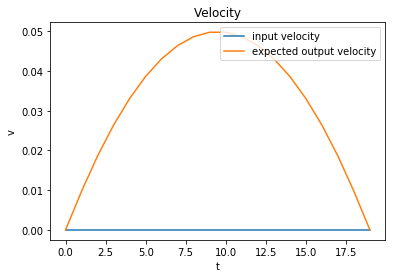

Random i = 58


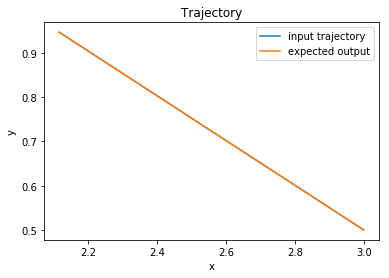

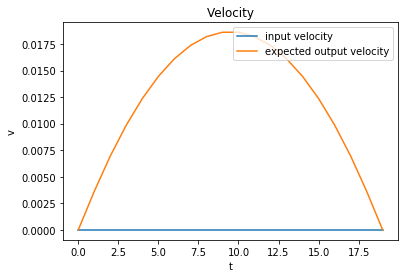

Random i = 192


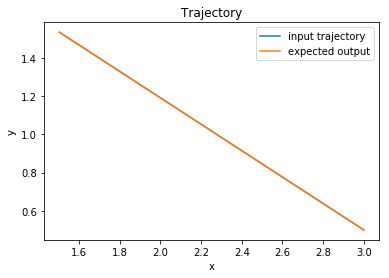

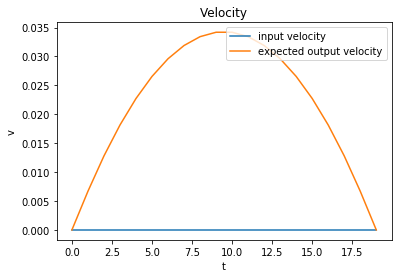

Random i = 248


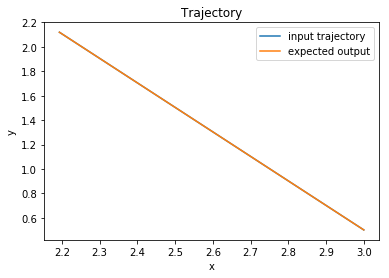

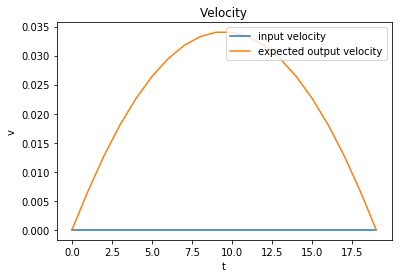

Test data
Random i = 146


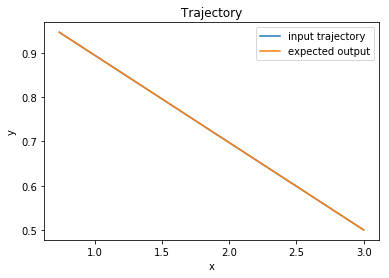

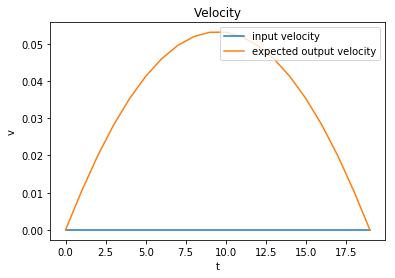

Random i = 73


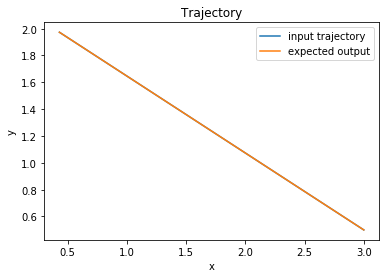

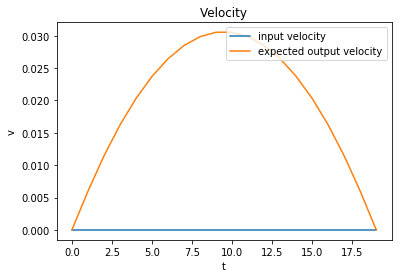

Random i = 38


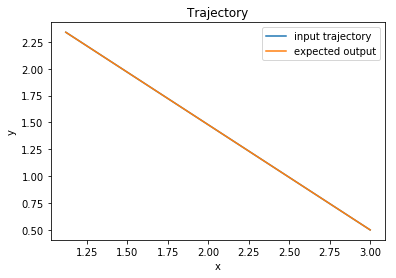

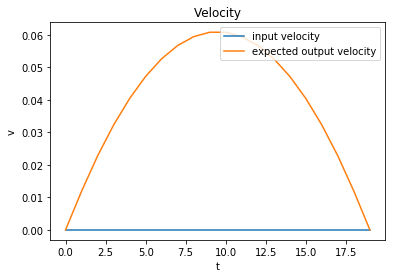

Random i = 21


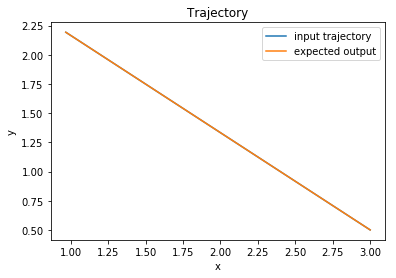

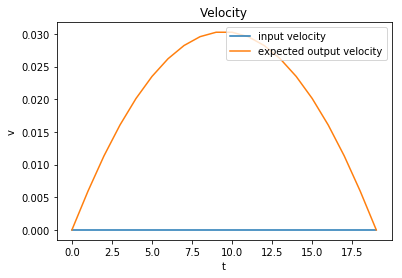

Random i = 102


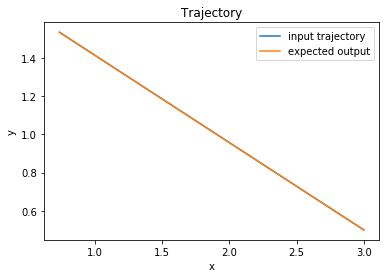

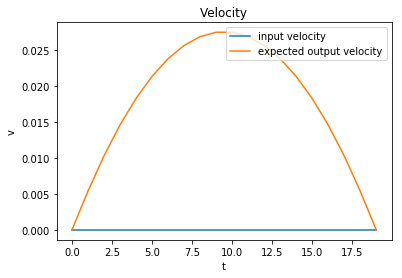

Random i = 30


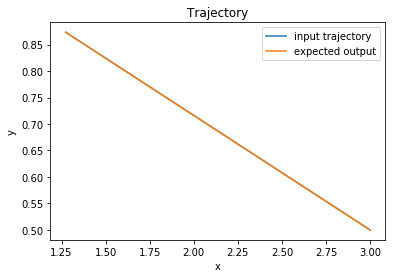

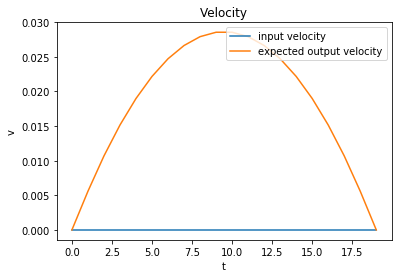

Random i = 89


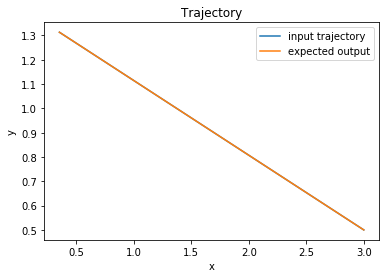

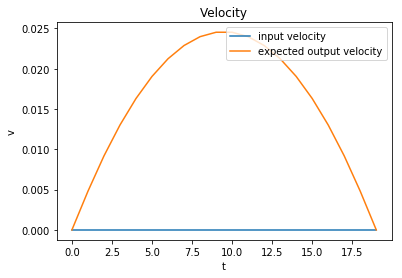

Random i = 93


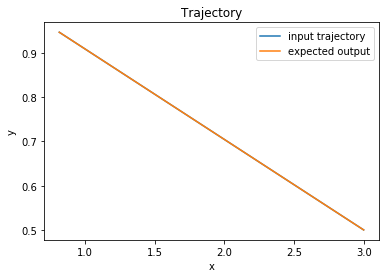

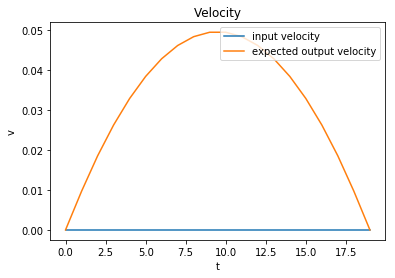

In [11]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])

print("Training data")
for x in range(8):
    i = random.randint(1,np.size(X_train,0)-1)
    print("Random i =",i)
    plotTrajectoryInputAndOutput(X_train[i,:],Y_train[i,:])
    plotVelocitiesInputAndOutput(X_train[i,:],Y_train[i,:])
print("Test data")
for x in range(8):
    i = random.randint(1,np.size(X_test,0)-1)
    print("Random i =",i)
    plotTrajectoryInputAndOutput(X_test[i,:],Y_test[i,:])
    plotVelocitiesInputAndOutput(X_train[i,:],Y_train[i,:])



### No obstacle, non-zero final velocity dataset

Training data
Random i = 15


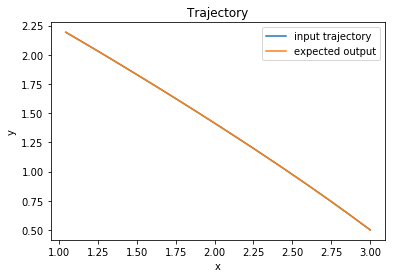

Random i = 570


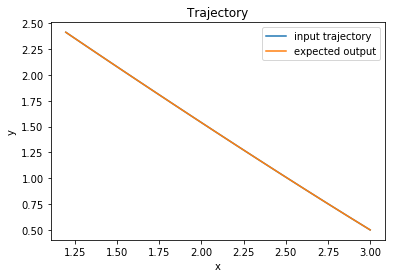

Random i = 616


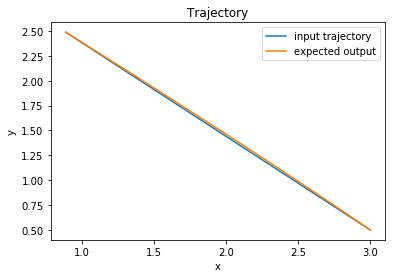

Random i = 457


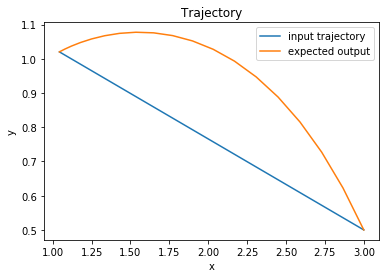

Random i = 13


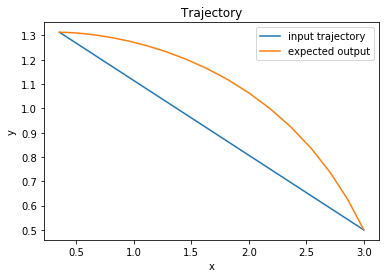

Test data
Random i = 199


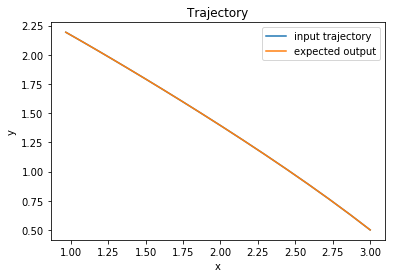

Random i = 288


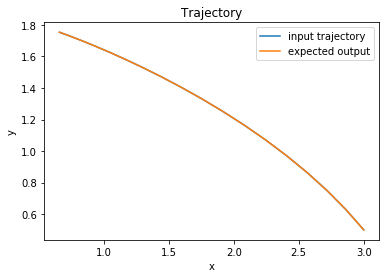

Random i = 251


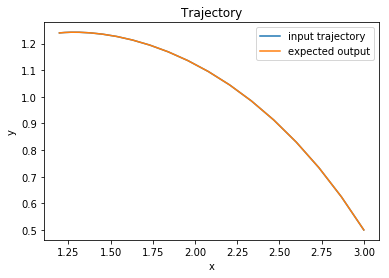

Random i = 21


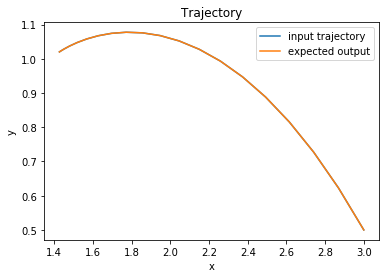

Random i = 230


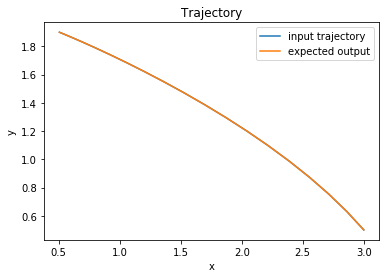

In [65]:
# (X_train, X_test, Y_train, Y_test) = loadData(["SingleObstacleFirst5Iter.jld2"], testRatio = 0.25)
# (X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVel.jld2"], testRatio = 0.25)
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOK.jld2"], testRatio = 0.25)
# (X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25)

# plotTrajectoryFromInput(X_train[i,:])
print("Training data")
for x in range(5):
    i = random.randint(1,np.size(X_train,0)-1)
    print("Random i =",i)
    plotTrajectoryInputAndOutput(X_train[i,:],Y_train[i,:])
print("Test data")
for x in range(5):
    i = random.randint(1,np.size(X_test,0)-1)
    print("Random i =",i)
    plotTrajectoryInputAndOutput(X_test[i,:],Y_test[i,:])

### Single obstacle, non-zero final velocity dataset

/usr/local/lib/python3.5/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Training data
Random i = 124


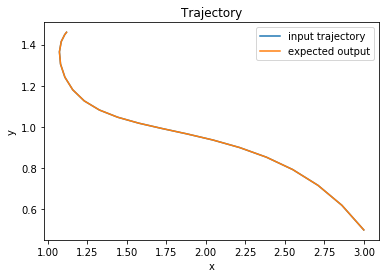

Random i = 252


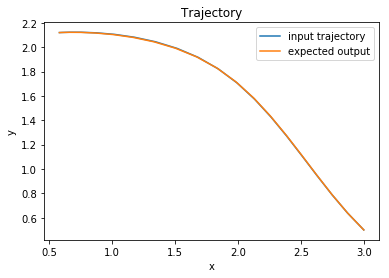

Random i = 2509


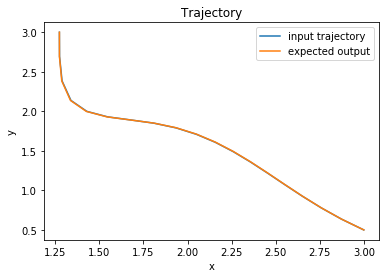

Random i = 801


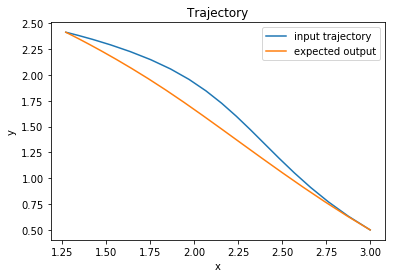

Random i = 781


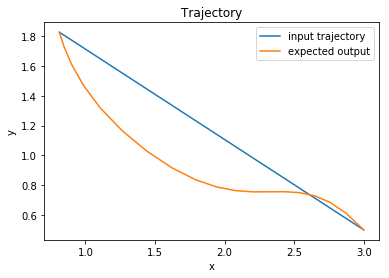

Test data
Random i = 869


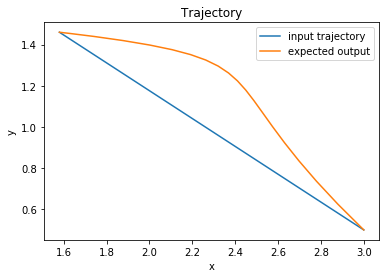

Random i = 823


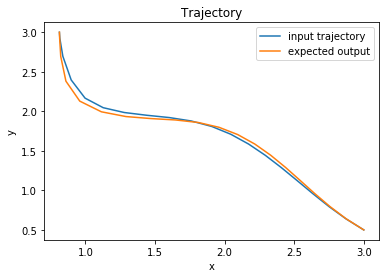

Random i = 604


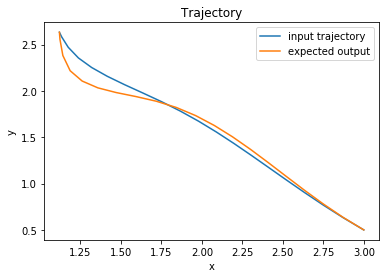

Random i = 56


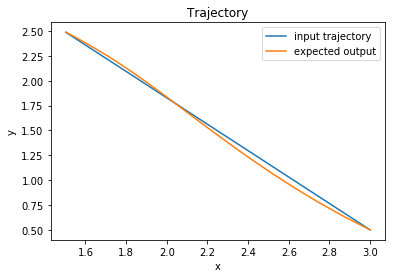

Random i = 608


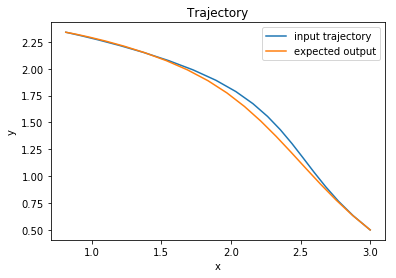

In [74]:
(X_train, X_test, Y_train, Y_test) = loadData(["SingleObstacleFirst5Iter.jld2"], testRatio = 0.25)
# (X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVel.jld2"], testRatio = 0.25)
# (X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOK.jld2"], testRatio = 0.25)
# (X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25)

# plotTrajectoryFromInput(X_train[i,:])
print("Training data")
for x in range(5):
    i = random.randint(1,np.size(X_train,0)-1)
    print("Random i =",i)
    plotTrajectoryInputAndOutput(X_train[i,:],Y_train[i,:])
print("Test data")
for x in range(5):
    i = random.randint(1,np.size(X_test,0)-1)
    print("Random i =",i)
    plotTrajectoryInputAndOutput(X_test[i,:],Y_test[i,:])

# Run model on some inputs and plot results

## Newer model, bigger network, first iteration only

### Try training data

In [12]:
model = load_model('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.h5')
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])

Idx = [94,78,257]
X_train_np_array=np.array(X_train)
NN_output = model.predict(X_train_np_array[Idx])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Training Examples


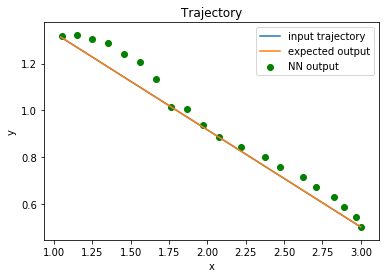

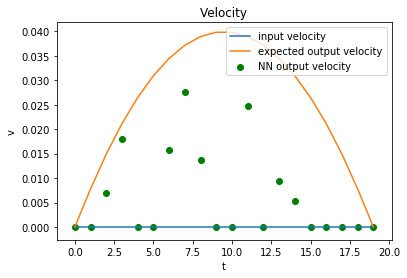

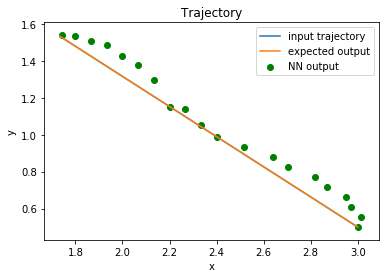

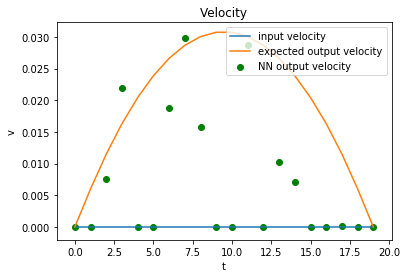

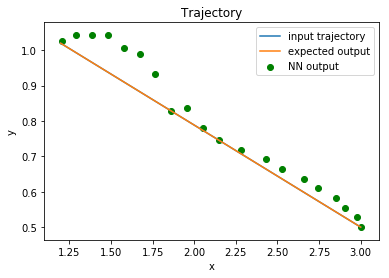

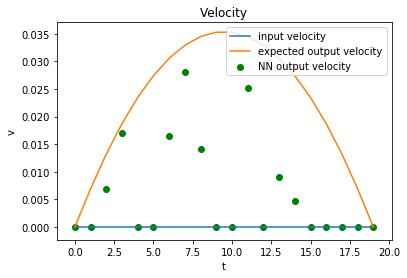

In [13]:
print("Training Examples")
for NN_idx, train_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])
    plotVelocitiesInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])


### Try test data

In [14]:
# model = load_model('NoObstacleFirst3IterOKDecayLRModel.h5')
Idx = [61,83,100, 123]
X_test_np_array=np.array(X_test)
NN_output = model.predict(X_test_np_array[Idx])

(4, 180)
Test Examples


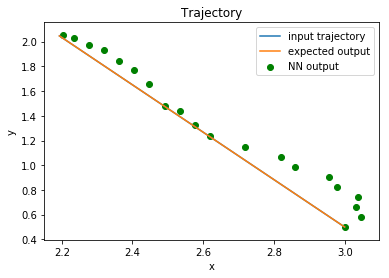

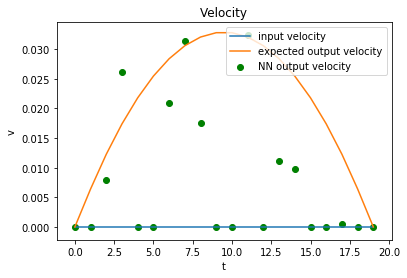

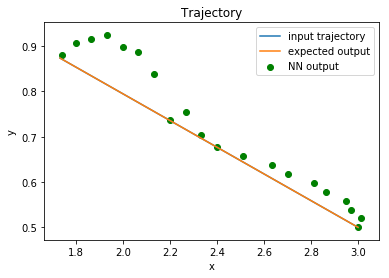

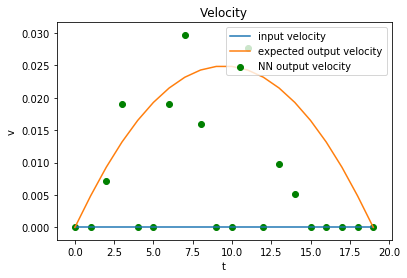

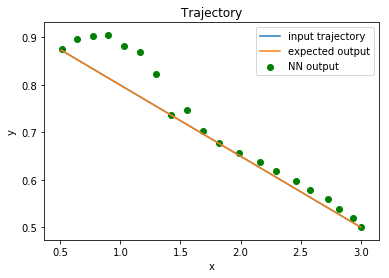

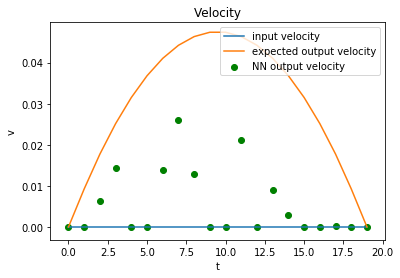

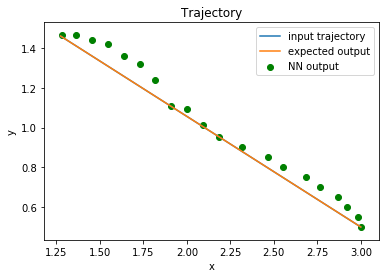

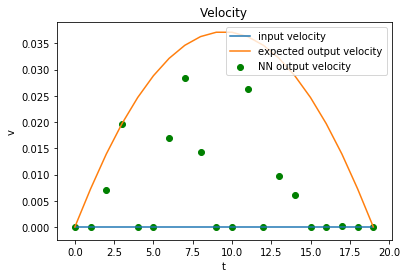

In [15]:
print(np.shape(NN_output))
print("Test Examples")
for NN_idx, test_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])
    plotVelocitiesInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])


## Older no obstacle, first 3 iter model

### Try training data

In [17]:
model = load_model('NoObstacleFirst3IterOKDecayLRModel.h5')
Idx = [94,78,257]
X_train_np_array=np.array(X_train)
NN_output = model.predict(X_train_np_array[Idx])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


(3, 180)
Training Examples


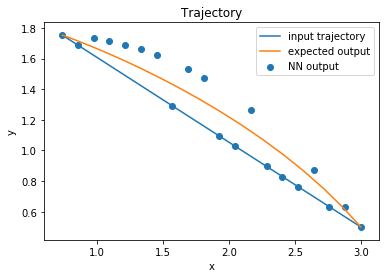

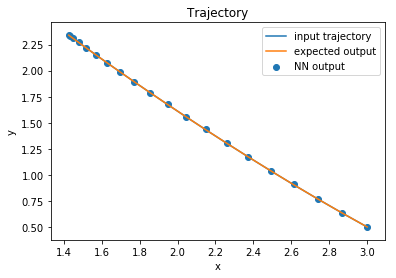

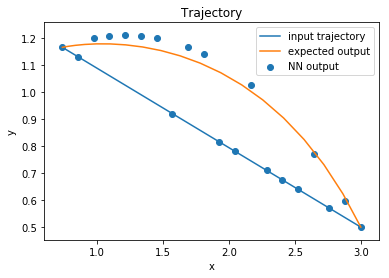

In [18]:
print(np.shape(NN_output))
print("Training Examples")
for NN_idx, train_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])


### Try test data

In [19]:
# model = load_model('NoObstacleFirst3IterOKDecayLRModel.h5')
Idx = [61,83,201,244]
X_test_np_array=np.array(X_test)
NN_output = model.predict(X_test_np_array[Idx])

(4, 180)
Test Examples


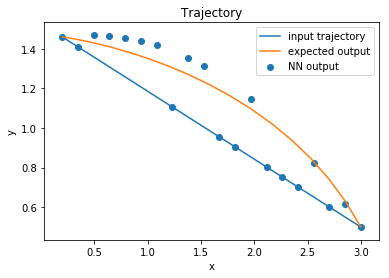

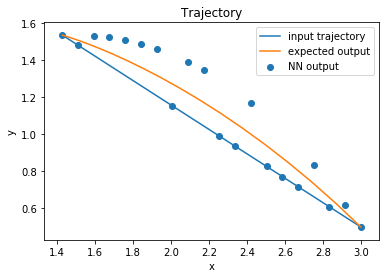

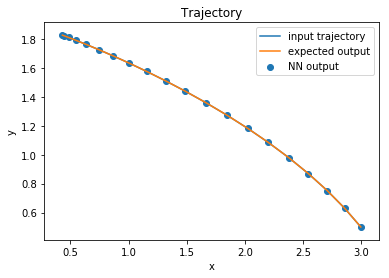

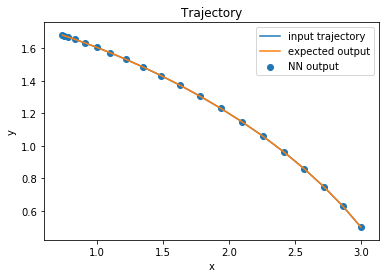

In [20]:
print(np.shape(NN_output))
print("Test Examples")
for NN_idx, test_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])


In [21]:
print(np.shape(NN_output))
diff = NN_output[0,:]-NN_output[1,:]
print(diff)

(4, 180)
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.06255436e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.66007739e-03 0.00000000e+00 1.70965958e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.48033416e-03
 0.00000000e+00 7.76452944e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.69686496e-03 0.00000000e+00 1.04209222e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.92436302e-03
 0.00000000e+00 9.97437164e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.71147013e-03 0.00000000e+00 1.59415044e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.54782557e-03 0.00000000e+00 1.12373009e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.53785872e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.14007480e-03
 0.00000000e+00

## Single obstacle, first 5 iter model

### Try training data

In [75]:
model = load_model('SingleObstacleFirst5IterDecayLRModel.h5')
(X_train, X_test, Y_train, Y_test) = loadData(["SingleObstacleFirst5Iter.jld2"], testRatio = 0.25)
Idx = [94,78,257]
X_train_np_array=np.array(X_train)
NN_output = model.predict(X_train_np_array[Idx])

(3, 180)
Training Examples


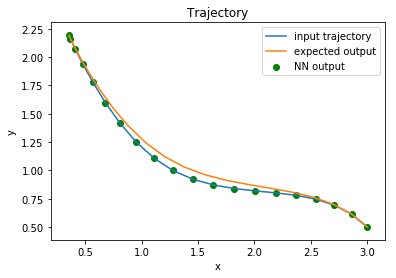

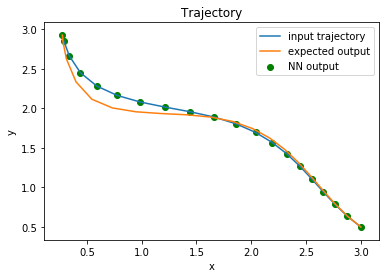

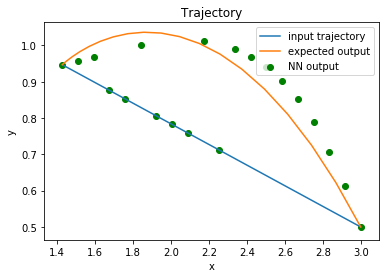

In [76]:
print(np.shape(NN_output))
print("Training Examples")
for NN_idx, train_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])


### Try test data

In [77]:
# model = load_model('NoObstacleFirst3IterOKDecayLRModel.h5')
Idx = [61,83,201,244]
X_test_np_array=np.array(X_test)
NN_output = model.predict(X_test_np_array[Idx])

(4, 180)
Test Examples


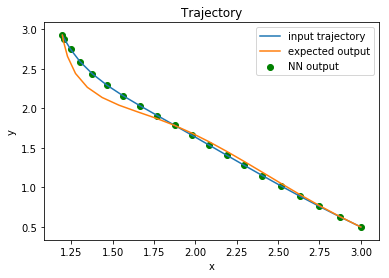

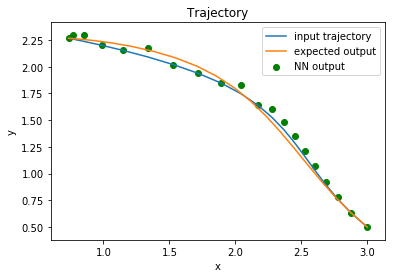

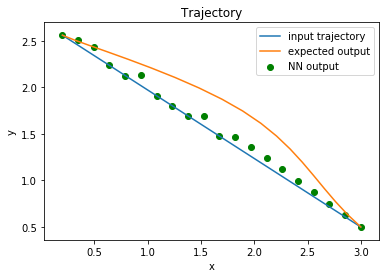

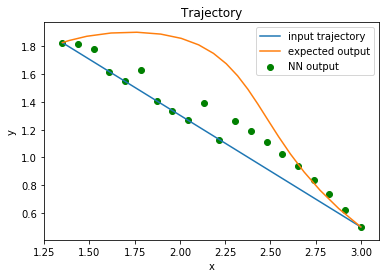

In [78]:
print(np.shape(NN_output))
print("Test Examples")
for NN_idx, test_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])


# Try to overfit! Bigger network and dataset with zero final velocity

In [42]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])
numSamples = 2
X_train = X_train[1:numSamples,:]
# X_test = X_test[1:4,:]
Y_train = Y_train[1:numSamples,:]
# Y_test = Y_test[1:4,:]

# create the model
model = Sequential()
model.add(Dense(512, input_dim=182, activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
customAdam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=customAdam, metrics=['mean_squared_error'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=1, min_lr=1e-50)

lrHist = []

In [43]:
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=1, verbose=1, callbacks=[reduce_lr, CustomMetrics()])

# evaluate the model
scores = model.evaluate(X_test, Y_test)

Train on 1 samples, validate on 162 samples
Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Learning rate:  0.001
Epoch 2/30
1/1 [==============================] - 0s 342ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Learning rate:  0.001
Epoch 3/30
1/1 [==============================] - 0s 355ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Learning rate:  0.001
Epoch 4/30
1/1 [==============================] - 0s 463ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Learning rate:  0.000100000005
Epoch 5/30
1/1 [==============================] - 0s 317ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Learning rate:  1.0000001e-05
Epoch 6/30
1/1 [================

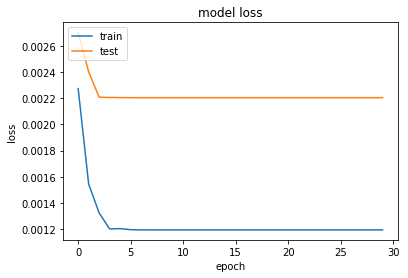

In [44]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

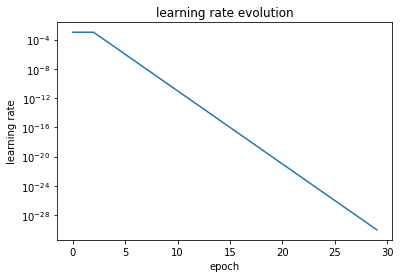

In [45]:
# show evolution of learning rate
plt.plot(lrHist)
plt.title('learning rate evolution')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.yscale('log')
plt.show()

In [123]:
# save model to hdf5 file
model.save('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.h5') 

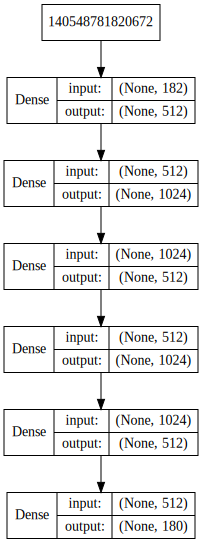

In [46]:
# plot_model(model, to_file='NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.png')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

# Try dataset with zero final velocity

In [51]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])
# create the model
model = Sequential()
model.add(Dense(256, input_dim=182, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(256, init='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
customAdam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=customAdam, metrics=['mean_squared_error'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-50)

lrHist = []

Instructions for updating:
Colocations handled automatically by placer.


In [52]:
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=5, verbose=1, callbacks=[reduce_lr, CustomMetrics()])

# evaluate the model
scores = model.evaluate(X_test, Y_test)

Instructions for updating:
Use tf.cast instead.
Train on 484 samples, validate on 162 samples
Epoch 1/100
484/484 [==============================] - 2s 5ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Learning rate:  0.001
Epoch 2/100
484/484 [==============================] - 1s 1ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Learning rate:  0.001
Epoch 3/100
484/484 [==============================] - 1s 1ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Learning rate:  0.001
Epoch 4/100
484/484 [==============================] - 1s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Learning rate:  0.001
Epoch 5/100
484/484 [==============================] - 1s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Lea

484/484 [==============================] - 1s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Learning rate:  1.0000001e-16
Epoch 43/100
484/484 [==============================] - 0s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Learning rate:  1.0000001e-16
Epoch 44/100
484/484 [==============================] - 0s 932us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Learning rate:  1.0000001e-16
Epoch 45/100
484/484 [==============================] - 0s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Learning rate:  1.0000001e-17
Epoch 46/100
484/484 [==============================] - 0s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Learning rate:  1.0000001e-17
Epoch 47/100
484/484 [===================

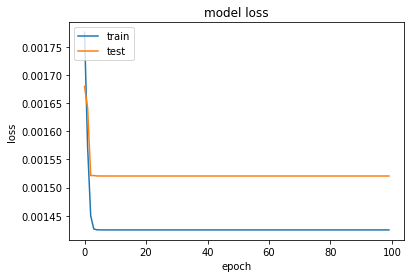

In [53]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

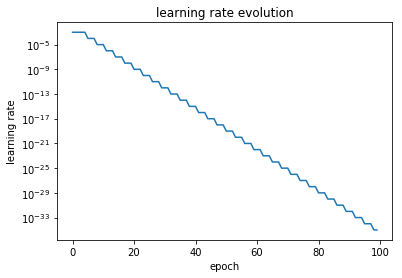

In [54]:
# show evolution of learning rate
plt.plot(lrHist)
plt.title('learning rate evolution')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.yscale('log')
plt.show()

In [55]:
# save model to hdf5 file
model.save('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.h5') 

# Try single obstacle dataset

In [67]:
(X_train, X_test, Y_train, Y_test) = loadData(["SingleObstacleFirst5Iter.jld2"], testRatio = 0.25)

/usr/local/lib/python3.5/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [68]:
# create the model
model = Sequential()
model.add(Dense(256, input_dim=182, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(256, init='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
customAdam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=customAdam, metrics=['mean_squared_error'])


In [69]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-50)

lrHist = []

# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=5, verbose=1, callbacks=[reduce_lr, CustomMetrics()])

# evaluate the model
scores = model.evaluate(X_test, Y_test)


Train on 2986 samples, validate on 996 samples
Epoch 1/100
2986/2986 [==============================] - 5s 2ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Learning rate:  1e-04
Epoch 2/100
2986/2986 [==============================] - 3s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Learning rate:  1e-04
Epoch 3/100
2986/2986 [==============================] - 3s 1ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Learning rate:  1e-04
Epoch 4/100
2986/2986 [==============================] - 3s 1ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Learning rate:  1e-04
Epoch 5/100
2986/2986 [==============================] - 3s 929us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Learning rate:  1e-05
Epoch 6/100
2986

2986/2986 [==============================] - 5s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Learning rate:  9.9999995e-33
Epoch 87/100
2986/2986 [==============================] - 5s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Learning rate:  9.9999995e-33
Epoch 88/100
2986/2986 [==============================] - 5s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Learning rate:  9.9999995e-33
Epoch 89/100
2986/2986 [==============================] - 5s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Learning rate:  9.999999e-34
Epoch 90/100
2986/2986 [==============================] - 4s 1ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Learning rate:  9.999999e-34
Epoch 91/100
2986/2986 [===========

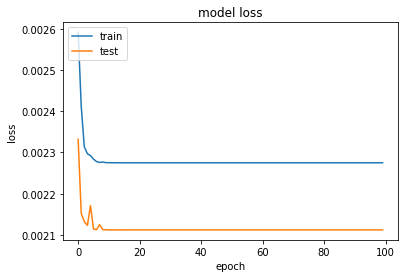

In [70]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [71]:
print(scores)
print(K.eval(model.optimizer.lr))
# save model to hdf5 file
model.save('SingleObstacleFirst5IterDecayLRModel.h5') 

[0.0021121721539498414, 0.0021121721539498414]
9.9999995e-37


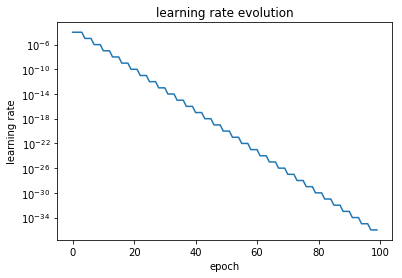

In [72]:
# show evolution of learning rate
plt.plot(lrHist)
plt.title('learning rate evolution')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.yscale('log')
plt.show()

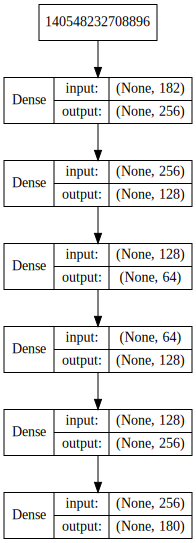

In [73]:
model = load_model('SingleObstacleFirst5IterDecayLRModel.h5')
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

# Track decrease in learning rate

In [166]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOK.jld2"], testRatio = 0.25)

(1278, 182)
(1278, 180)
(958, 182)
(320, 182)
(958, 180)
(320, 180)


In [167]:
# create the model
model = Sequential()
model.add(Dense(256, input_dim=182, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(256, init='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
customAdam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=customAdam, metrics=['mean_squared_error'])


In [168]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-50)

lrHist = []

# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=5, verbose=1, callbacks=[reduce_lr, CustomMetrics()])

# evaluate the model
scores = model.evaluate(X_test, Y_test)


Train on 958 samples, validate on 320 samples
Epoch 1/100
958/958 [==============================] - 5s 5ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Learning rate:  1e-04
Epoch 2/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Learning rate:  1e-04
Epoch 3/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Learning rate:  1e-04
Epoch 4/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Learning rate:  1e-04
Epoch 5/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Learning rate:  1e-04
Epoch 6/100
958/958 [========

958/958 [==============================] - 1s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Learning rate:  9.999999e-18
Epoch 45/100
958/958 [==============================] - 1s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Learning rate:  9.999999e-18
Epoch 46/100
958/958 [==============================] - 2s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Learning rate:  9.999999e-19
Epoch 47/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Learning rate:  9.999999e-19
Epoch 48/100
958/958 [==============================] - 2s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Learning rate:  9.999999e-19
Epoch 49/100
958/958 [==========================

Learning rate:  1e-31
Epoch 88/100
958/958 [==============================] - 2s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Learning rate:  9.9999995e-33
Epoch 89/100
958/958 [==============================] - 2s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Learning rate:  9.9999995e-33
Epoch 90/100
958/958 [==============================] - 2s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Learning rate:  9.9999995e-33
Epoch 91/100
958/958 [==============================] - 2s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Learning rate:  9.999999e-34
Epoch 92/100
958/958 [==============================] - 2s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Learning rate:  9.999999e-34
Epoch 93/1

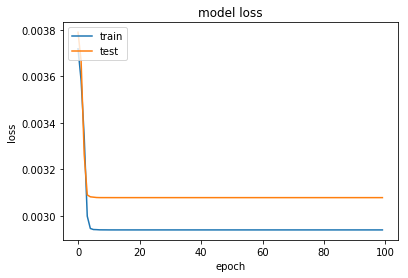

In [169]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [170]:
print(scores)
print(K.eval(model.optimizer.lr))
# save model to hdf5 file
model.save('NoObstacleFirst3IterOKDecayLRModel.h5') 

[0.003078610880766064, 0.003078610880766064]
9.9999995e-37


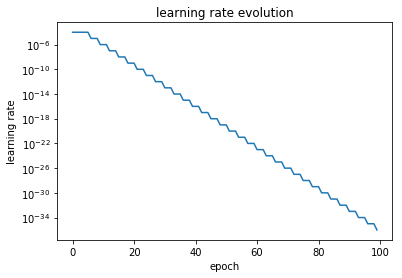

In [171]:
# show evolution of learning rate
plt.plot(lrHist)
plt.title('learning rate evolution')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.yscale('log')
plt.show()

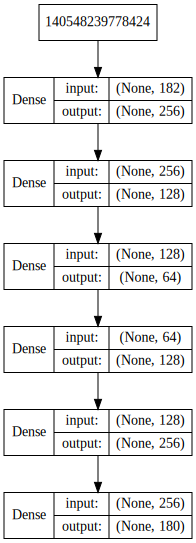

In [66]:
model = load_model('NoObstacleFirst3IterOKDecayLRModel.h5')
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

# Simple no obstacle dataset - ends in ok batch

In [81]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOK.jld2"], testRatio = 0.25)
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(Y_train))
print(np.shape(Y_test))

(1278, 182)
(1278, 180)
(958, 182)
(320, 182)
(958, 180)
(320, 180)
(958, 182)
(320, 182)
(958, 180)
(320, 180)


In [58]:
# create the model
model = Sequential()
model.add(Dense(256, input_dim=182, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(256, init='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])



In [16]:
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=5, verbose=1)

# evaluate the model
scores = model.evaluate(X_test, Y_test)

Train on 958 samples, validate on 320 samples
Epoch 1/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 2/100
958/958 [==============================] - 1s 932us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 3/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 4/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 5/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 6/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0023 - val_m

Epoch 100/100
320/320 [==============================] - 0s 42us/step


In [17]:
histSimple.history.keys()

dict_keys(['val_loss', 'val_mean_squared_error', 'mean_squared_error', 'loss'])

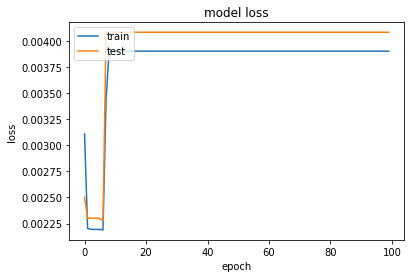

In [18]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# use lower learning rate on plateau

In [66]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOK.jld2"], testRatio = 0.25)

(1278, 182)
(1278, 180)
(958, 182)
(320, 182)
(958, 180)
(320, 180)


In [67]:
# create the model
model = Sequential()
model.add(Dense(256, input_dim=182, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(256, init='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])



In [68]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.0001)
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=5, verbose=1, callbacks=[reduce_lr])

# evaluate the model
scores = model.evaluate(X_test, Y_test)


Train on 958 samples, validate on 320 samples
Epoch 1/100
958/958 [==============================] - 2s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 2/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 3/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 4/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 5/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 6/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mea

Epoch 51/100
958/958 [==============================] - 2s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 52/100
958/958 [==============================] - 2s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 53/100
958/958 [==============================] - 2s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 54/100
958/958 [==============================] - 2s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 55/100
958/958 [==============================] - 2s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 56/100
958/958 [==============================] - 2s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 57/100
958

320/320 [==============================] - 0s 56us/step


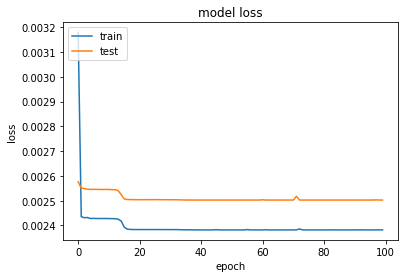

In [69]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [70]:
print(scores)

[0.0025025378912687303, 0.0025025378912687303]


# use custom optimizer for lower starting learning rate

In [73]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOK.jld2"], testRatio = 0.25)

(1278, 182)
(1278, 180)
(958, 182)
(320, 182)
(958, 180)
(320, 180)


In [74]:
# create the model
model = Sequential()
model.add(Dense(256, input_dim=182, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(256, init='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
customAdam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=customAdam, metrics=['mean_squared_error'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])



In [75]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.0000001)
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=5, verbose=1, callbacks=[reduce_lr])

# evaluate the model
scores = model.evaluate(X_test, Y_test)


Train on 958 samples, validate on 320 samples
Epoch 1/100
958/958 [==============================] - 2s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 2/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 3/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 4/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 5/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 6/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0037 - val_mea

Epoch 51/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 52/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 53/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 54/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 55/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 56/100
958/958 [==============================] - 1s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 57/100
958

320/320 [==============================] - 0s 71us/step


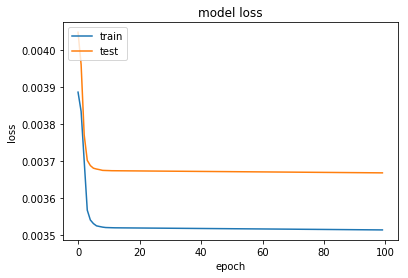

In [76]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [77]:
print(scores)

[0.003668231028132141, 0.003668231028132141]


# Normalize data first

In [52]:
# x = X_train[1,:]
# x= [[0.0001, 0.1, -0.0000000003, -0.000000005],[2,2,2,2]]
# print(x)
# y = X_train[:,0:180]
# print(np.shape(y))
# xNormalized = normalize(
#     x,
#     axis=1,
#     order=2
# )
# print(xNormalized)
print(np.shape(X_train))
print(X_train[1,0:10])
X_norms = np.linalg.norm(X_train, axis=0)
print(np.shape(X_norms))
print(X_norms[0:10])
# Inspired by implementation of keras normalize https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/python/keras/utils/np_utils.py
X_norms[X_norms == 0] = 1
print(X_norms[0:10])
X_train_normalized = X_train/X_norms
print(np.shape(X_train_normalized))
print(X_train_normalized[1,0:10])

(958, 182)
[0.27666667 2.48666667 0.         0.         0.         0.
 0.42       2.38210526 0.         0.00263158]
(182,)
[28.96384394 53.05486217  0.          0.          0.          0.
 30.14854155 52.32393817  0.          0.21503688]
[28.96384394 53.05486217  1.          1.          1.          1.
 30.14854155 52.32393817  1.          0.21503688]
(958, 182)
[0.00955214 0.04686972 0.         0.         0.         0.
 0.01393102 0.04552611 0.         0.0122378 ]


# Simple no obstacle dataset - small batch

In [25]:
(X_train, X_test, Y_train, Y_test) = loadData(["thirdBatch.jld2"], testRatio = 0.25)

(1671, 182)
(1671, 180)
(1253, 182)
(418, 182)
(1253, 180)
(418, 180)


In [26]:
# create the model
model = Sequential()
model.add(Dense(256, input_dim=182, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(256, init='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])



Instructions for updating:
Colocations handled automatically by placer.


In [27]:
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=5, verbose=1)

# evaluate the model
scores = model.evaluate(X_test, Y_test)

Instructions for updating:
Use tf.cast instead.
Train on 1253 samples, validate on 418 samples
Epoch 1/100
1253/1253 [==============================] - 3s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2/100
1253/1253 [==============================] - 1s 911us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 3/100
1253/1253 [==============================] - 1s 926us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 4/100
1253/1253 [==============================] - 1s 920us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 5/100
1253/1253 [==============================] - 1s 1ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 6/100
1253/1253 [==============================] - 1s 958us/step - l

Epoch 97/100
1253/1253 [==============================] - 1s 608us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 98/100
1253/1253 [==============================] - 1s 642us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 99/100
1253/1253 [==============================] - 1s 596us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 100/100
418/418 [==============================] - 0s 38us/step


In [32]:
histSimple.history.keys()

dict_keys(['mean_squared_error', 'val_mean_squared_error', 'val_loss', 'loss'])

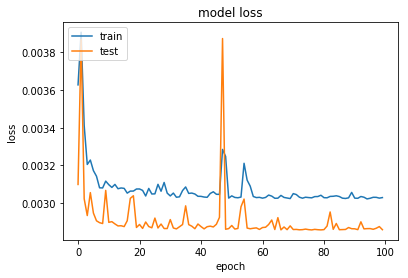

In [33]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

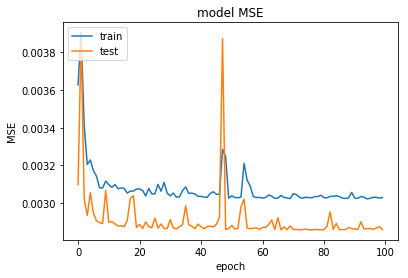

In [34]:
# summarize history for loss
plt.plot(histSimple.history['mean_squared_error'])
plt.plot(histSimple.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# No obstacle dataset - medium batch NoObstacleFirst3Iter

In [35]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3Iter.jld2"], testRatio = 0.25)

(1026, 182)
(1026, 180)
(769, 182)
(257, 182)
(769, 180)
(257, 180)


In [36]:
# create the model
model = Sequential()
model.add(Dense(256, input_dim=182, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(256, init='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])



In [37]:
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=5, verbose=1)

# evaluate the model
scores = model.evaluate(X_test, Y_test)

Train on 769 samples, validate on 257 samples
Epoch 1/100
769/769 [==============================] - 1s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 2/100
769/769 [==============================] - 1s 967us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 3/100
769/769 [==============================] - 1s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 4/100
769/769 [==============================] - 1s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 5/100
769/769 [==============================] - 1s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 6/100
769/769 [==============================] - 1s 997us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0038 - val

Epoch 100/100
257/257 [==============================] - 0s 68us/step


In [38]:
histSimple.history.keys()

dict_keys(['mean_squared_error', 'val_mean_squared_error', 'val_loss', 'loss'])

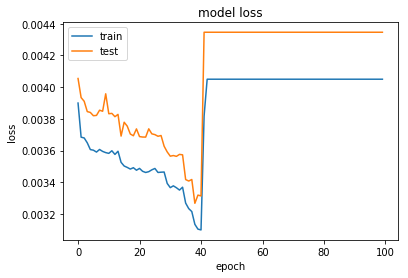

In [39]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Single obstacle dataset - medium batch SingleObstacleFirst5Iter

In [40]:
(X_train, X_test, Y_train, Y_test) = loadData(["SingleObstacleFirst5Iter.jld2"], testRatio = 0.25)

(3982, 182)
(3982, 180)
(2986, 182)
(996, 182)
(2986, 180)
(996, 180)


In [41]:
# create the model
model = Sequential()
model.add(Dense(256, input_dim=182, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(256, init='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])



In [42]:
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=5, verbose=1)

# evaluate the model
scores = model.evaluate(X_test, Y_test)

Train on 2986 samples, validate on 996 samples
Epoch 1/100
2986/2986 [==============================] - 3s 1ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 2/100
2986/2986 [==============================] - 3s 961us/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 3/100
2986/2986 [==============================] - 3s 986us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 4/100
2986/2986 [==============================] - 3s 988us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 5/100
2986/2986 [==============================] - 3s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 6/100
2986/2986 [==============================] - 3s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_los

Epoch 50/100
2986/2986 [==============================] - 2s 815us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 51/100
2986/2986 [==============================] - 2s 654us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 52/100
2986/2986 [==============================] - 2s 754us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 53/100
2986/2986 [==============================] - 2s 709us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 54/100
2986/2986 [==============================] - 2s 719us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 55/100
2986/2986 [==============================] - 4s 1ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0017 - val_mean_squared_error: 0

2986/2986 [==============================] - 4s 1ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 100/100
996/996 [==============================] - 0s 46us/step


In [43]:
histSimple.history.keys()

dict_keys(['mean_squared_error', 'val_mean_squared_error', 'val_loss', 'loss'])

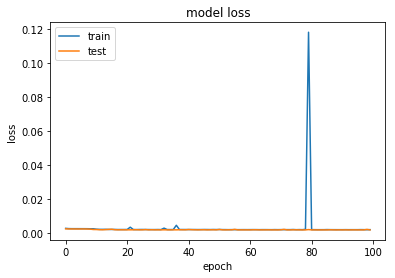

In [44]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
# save model to hdf5 file
model.save('SingleObstacleFirst5IterModel.h5') 

# Training on first and second batch

In [23]:
(X_train, X_test, Y_train, Y_test) = loadData(["firstBatch.jld2", "secondBatch.jld2"])

(5021, 182)
(5021, 180)
(3765, 182)
(1256, 182)
(3765, 180)
(1256, 180)


In [3]:
# load dataset
PATH_FILE_TRAINING1 = os.getcwd()+"/firstBatch.jld2"
PATH_FILE_TRAINING2 = os.getcwd()+"/secondBatch.jld2"

f1 = h5py.File(PATH_FILE_TRAINING1, "r")
f2 = h5py.File(PATH_FILE_TRAINING2, "r")


In [4]:
# split into input and output variables
X1       = f1["train_input_collected"].value;     
X1      = X1.transpose();
Y1        = f1["train_output_collected"].value;      
Y1       = Y1.transpose();
X2       = f2["train_input_collected"].value;     
X2      = X2.transpose();
Y2        = f2["train_output_collected"].value;      
Y2       = Y2.transpose();
X = np.vstack((X1,X2))
Y = np.vstack((Y1,Y2))

# split the data into training (75%) and testing (25%)
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.25, random_state=seed)

# Examine shape of data
print(np.shape(X))
print(np.shape(Y))
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(Y_train))
print(np.shape(Y_test))


/usr/local/lib/python3.5/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


(5021, 182)
(5021, 180)
(3765, 182)
(1256, 182)
(3765, 180)
(1256, 180)


In [5]:
# create the model
model = Sequential()
model.add(Dense(256, input_dim=182, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(256, init='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])



Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# fit the model
hist = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=5, verbose=1)

# evaluate the model
scores = model.evaluate(X_test, Y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 3765 samples, validate on 1256 samples
Epoch 1/10
3765/3765 [==============================] - 6s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 2/10
3765/3765 [==============================] - 6s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 3/10
3765/3765 [==============================] - 5s 1ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 4/10
3765/3765 [==============================] - 4s 1ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 5/10
3765/3765 [==============================] - 4s 1ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 6/10
3765/3765 [==============================] - 4s 1ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0023 -

In [13]:
hist.history.keys()

dict_keys(['val_loss', 'loss', 'mean_squared_error', 'val_mean_squared_error'])

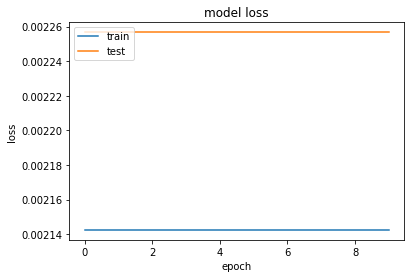

In [17]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

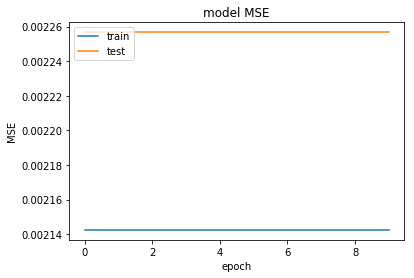

In [18]:
# summarize history for loss
plt.plot(hist.history['mean_squared_error'])
plt.plot(hist.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
Y_train[1]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.48919125e-01,  8.46208344e-02,
        0.00000000e+00,  4.06297214e-02, -1.89046252e-03,  0.00000000e+00,
        5.14810587e-01,  1.34864980e-01,  0.00000000e+00,  3.59615863e-02,
       -1.26841304e-03,  0.00000000e+00,  7.58682711e-01,  1.70820415e-01,
        0.00000000e+00,  1.21828892e-02,  6.57840457e-04,  0.00000000e+00,
        8.09750363e-01,  1.99755131e-01,  0.00000000e+00, -5.93442122e-03,
        2.66080827e-03,  0.00000000e+00,  7.27607089e-01,  2.22476637e-01,
        0.00000000e+00, -1.83903447e-02,  4.74048846e-03,  0.00000000e+00,
        5.71846436e-01,  2.39792435e-01,  0.00000000e+00, -2.51848812e-02,
        6.89688148e-03,  0.00000000e+00,  4.02061952e-01,  2.52510033e-01,
        0.00000000e+00, -2.63180303e-02,  9.12998854e-03,  0.00000000e+00,
        2.70658408e-01,  2.58752617e-01,  0.00000000e+00, -2.31556607e-02,
        1.09297866e-02,  